C:\Users\adame\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\adame\AppData\Local\Temp\ipykernel_32788\1324434248.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
C:\Users\adame\AppData\Local\Temp\ipykernel_32788\1324434248.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(method='ffill')


Epoch [1/20], Loss: 0.3734
Epoch [2/20], Loss: 0.3604
Epoch [3/20], Loss: 0.3480
Epoch [4/20], Loss: 0.3360
Epoch [5/20], Loss: 0.3241
Epoch [6/20], Loss: 0.3119
Epoch [7/20], Loss: 0.2992
Epoch [8/20], Loss: 0.2858
Epoch [9/20], Loss: 0.2713
Epoch [10/20], Loss: 0.2554
Epoch [11/20], Loss: 0.2378
Epoch [12/20], Loss: 0.2184
Epoch [13/20], Loss: 0.1971
Epoch [14/20], Loss: 0.1738
Epoch [15/20], Loss: 0.1492
Epoch [16/20], Loss: 0.1249
Epoch [17/20], Loss: 0.1037
Epoch [18/20], Loss: 0.0905
Epoch [19/20], Loss: 0.0904
Epoch [20/20], Loss: 0.1011
Ensemble MSE: 1.8375803983385282, R²: 0.9032973961308586
LSTM MSE: 56.58016586303711, R²: -1.664347458362648


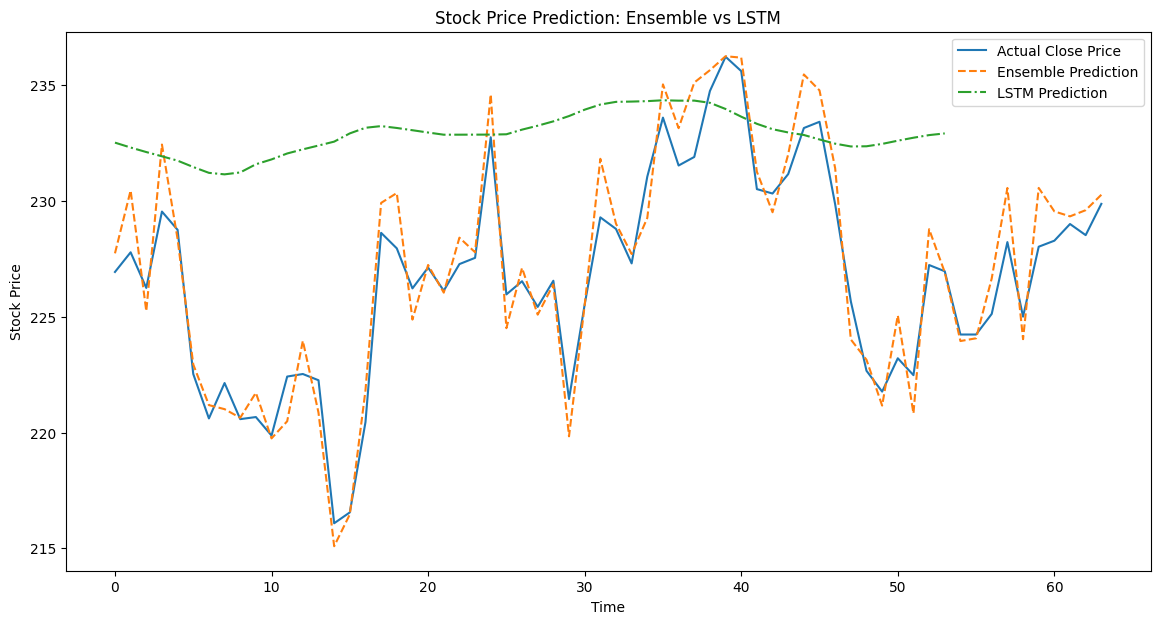

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Function to get stock data
def get_stock_data(ticker_symbol, period="6mo"):
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period=period)
    financials = ticker.quarterly_financials
    return hist, financials

# Function to create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Get Apple's stock data for the last 6 months
apple_hist, apple_financials = get_stock_data("AAPL", period="6mo")

# Process historical data
apple_hist = apple_hist.reset_index()
apple_hist['Date'] = apple_hist['Date'].dt.tz_localize(None)

# Process financial data
apple_financials = apple_financials.T
apple_financials = apple_financials.reset_index()
apple_financials = apple_financials.rename(columns={'index': 'Date'})
apple_financials['Date'] = pd.to_datetime(apple_financials['Date'])

# Merge historical and financial data
df = pd.merge_asof(apple_hist.sort_values('Date'), 
                   apple_financials.sort_values('Date'), 
                   on='Date', 
                   direction='forward')

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Total Revenue', 'Net Income', 'Basic EPS']
df = df[['Date'] + features]

# Fill NaN values in financial columns with the last known value
for col in ['Total Revenue', 'Net Income', 'Basic EPS']:
    df[col] = df[col].fillna(method='ffill')

# Drop any remaining rows with NaN values
df = df.dropna()

# Calculate the split point for 3 months of training and 3 months of testing
train_end = df['Date'].max() - timedelta(days=90)
test_start = train_end + timedelta(days=1)

df_train = df[df['Date'] <= train_end]
df_test = df[df['Date'] > train_end]

# Normalize the data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train[features])
test_scaled = scaler.transform(df_test[features])

# Create sequences for LSTM
sequence_length = 10
X_train_lstm, y_train_lstm = create_sequences(train_scaled, sequence_length)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, sequence_length)

# Convert to PyTorch tensors
X_train_lstm = torch.FloatTensor(X_train_lstm)
y_train_lstm = torch.FloatTensor(y_train_lstm)
X_test_lstm = torch.FloatTensor(X_test_lstm)
y_test_lstm = torch.FloatTensor(y_test_lstm)

# Prepare data for traditional ML models
X_train_ml = df_train[features].values
y_train_ml = df_train['Close'].values  # Predicting the 'Close' price
X_test_ml = df_test[features].values
y_test_ml = df_test['Close'].values

# Train-Test Split for ML models
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(X_train_ml, y_train_ml, test_size=0.2, random_state=42)

# Ensemble Machine Learning Models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
svr = SVR(kernel='rbf')

# Train individual models
rf.fit(X_train_ml, y_train_ml)
gbr.fit(X_train_ml, y_train_ml)
svr.fit(X_train_ml, y_train_ml)

# Predictions from each model
rf_pred = rf.predict(X_val_ml)
gbr_pred = gbr.predict(X_val_ml)
svr_pred = svr.predict(X_val_ml)

# Combine predictions using a meta-model (Linear Regression)
ensemble_input = np.vstack((rf_pred, gbr_pred, svr_pred)).T
meta_model = LinearRegression()
meta_model.fit(ensemble_input, y_val_ml)

# Predict on the test set using the ensemble
rf_test_pred = rf.predict(X_test_ml)
gbr_test_pred = gbr.predict(X_test_ml)
svr_test_pred = svr.predict(X_test_ml)
ensemble_test_input = np.vstack((rf_test_pred, gbr_test_pred, svr_test_pred)).T
ensemble_pred = meta_model.predict(ensemble_test_input)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=2, output_size=8):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Training Function
def train_model(model, X_train, y_train, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Train the LSTM Model
lstm_model = LSTMModel(input_size=8, hidden_size=64, num_layers=2, output_size=8)
train_model(lstm_model, X_train_lstm, y_train_lstm, num_epochs=20, lr=0.001)

# LSTM Prediction on Test Data
lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = lstm_model(X_test_lstm)

# Convert predictions and actual values back to their original scale for comparison
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm.numpy())
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.numpy())

# Evaluation Metrics
ensemble_mse = mean_squared_error(y_test_ml, ensemble_pred)
ensemble_r2 = r2_score(y_test_ml, ensemble_pred)

lstm_mse = mean_squared_error(y_test_lstm_rescaled[:, 0], y_pred_lstm_rescaled[:, 0])
lstm_r2 = r2_score(y_test_lstm_rescaled[:, 0], y_pred_lstm_rescaled[:, 0])

print(f'Ensemble MSE: {ensemble_mse}, R²: {ensemble_r2}')
print(f'LSTM MSE: {lstm_mse}, R²: {lstm_r2}')

# Visualization of Ensemble vs LSTM Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml, label="Actual Close Price")
plt.plot(ensemble_pred, label="Ensemble Prediction", linestyle='--')
plt.plot(y_pred_lstm_rescaled[:, 0], label="LSTM Prediction", linestyle='-.')
plt.legend()
plt.title('Stock Price Prediction: Ensemble vs LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()


Best LSTM Hyperparameters: (64, 2, 0.005, 0.3)
Best Validation Loss: 0.006300079636275768
Ensemble MAE: 1.093699763780302, RMSE: 1.3555738262221384
LSTM MAE: 3.604820489883423, RMSE: 4.484256267547607
Diebold-Mariano Test Statistic: -2.9172619504996384, p-value: 0.0048885931217066995
Training Data: 64 rows (50.00% of total data)
Testing Data: 64 rows (50.00% of total data)


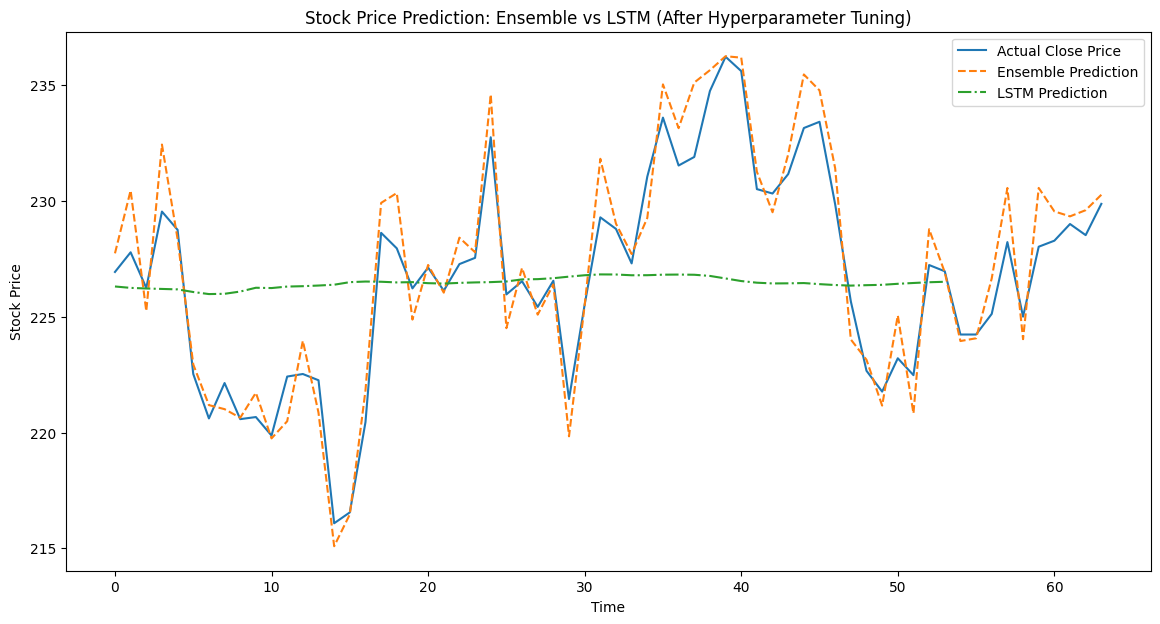

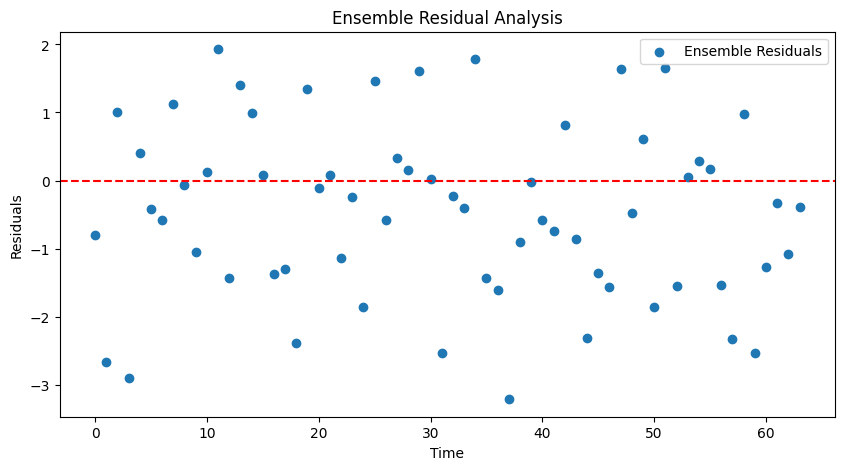

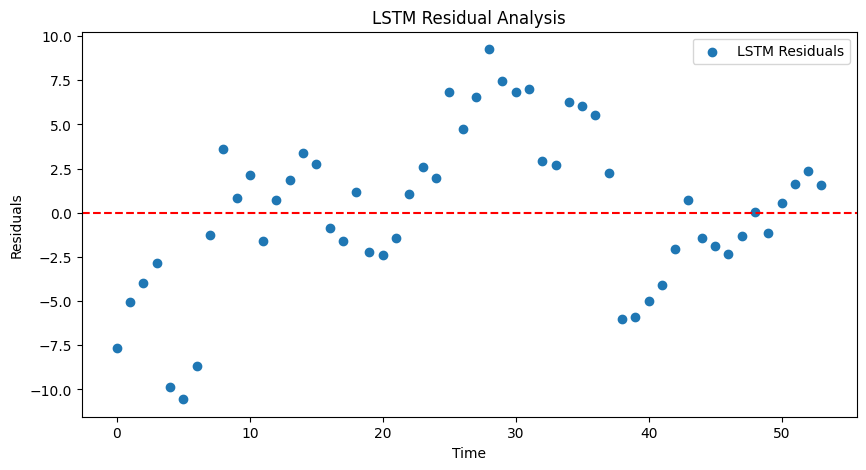

In [3]:
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ttest_rel

# Modified LSTM Model with Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=2, output_size=8, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Function to train the LSTM Model with regularization and hyperparameter tuning
def train_and_evaluate_lstm(params, X_train, y_train, X_val, y_val, num_epochs=20):
    hidden_size, num_layers, lr, dropout_prob = params
    model = LSTMModel(input_size=8, hidden_size=hidden_size, num_layers=num_layers, dropout_prob=dropout_prob)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_model = None
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

        # Track best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

    return best_model, train_losses, val_losses

# Sample Grid Search for LSTM Hyperparameters
param_grid = {
    'hidden_size': [32, 64],
    'num_layers': [2, 3],
    'lr': [0.001, 0.005],
    'dropout_prob': [0.2, 0.3]
}

# Create combinations of hyperparameters
param_combinations = list(itertools.product(param_grid['hidden_size'],
                                            param_grid['num_layers'],
                                            param_grid['lr'],
                                            param_grid['dropout_prob']))

# Split train data into train and validation for tuning
train_split = int(0.8 * len(X_train_lstm))
X_train_tune = X_train_lstm[:train_split]
y_train_tune = y_train_lstm[:train_split]
X_val_tune = X_train_lstm[train_split:]
y_val_tune = y_train_lstm[train_split:]

# Hyperparameter tuning
best_model = None
best_params = None
best_val_loss = float('inf')

for params in param_combinations:
    model, train_losses, val_losses = train_and_evaluate_lstm(params, X_train_tune, y_train_tune, X_val_tune, y_val_tune)
    if min(val_losses) < best_val_loss:
        best_val_loss = min(val_losses)
        best_model = model
        best_params = params

print(f'Best LSTM Hyperparameters: {best_params}')
print(f'Best Validation Loss: {best_val_loss}')

# Use the best model for final testing
best_model.eval()
with torch.no_grad():
    y_pred_lstm = best_model(X_test_lstm)

# Convert predictions and actual values back to their original scale
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm.numpy())
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.numpy())

# Additional Metrics
ensemble_mae = mean_absolute_error(y_test_ml, ensemble_pred)
ensemble_rmse = mean_squared_error(y_test_ml, ensemble_pred, squared=False)

lstm_mae = mean_absolute_error(y_test_lstm_rescaled[:, 0], y_pred_lstm_rescaled[:, 0])
lstm_rmse = mean_squared_error(y_test_lstm_rescaled[:, 0], y_pred_lstm_rescaled[:, 0], squared=False)

print(f'Ensemble MAE: {ensemble_mae}, RMSE: {ensemble_rmse}')
print(f'LSTM MAE: {lstm_mae}, RMSE: {lstm_rmse}')

# Diebold-Mariano Test (Comparing Ensemble vs LSTM)
dm_test_stat, p_value = ttest_rel(y_test_ml, ensemble_pred)
print(f'Diebold-Mariano Test Statistic: {dm_test_stat}, p-value: {p_value}')

# Visualization of Data Splits
train_size = len(df_train)
test_size = len(df_test)
total_size = len(df)
print(f"Training Data: {train_size} rows ({train_size/total_size:.2%} of total data)")
print(f"Testing Data: {test_size} rows ({test_size/total_size:.2%} of total data)")

# Visualization of Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_ml, label="Actual Close Price")
plt.plot(ensemble_pred, label="Ensemble Prediction", linestyle='--')
plt.plot(y_pred_lstm_rescaled[:, 0], label="LSTM Prediction", linestyle='-.')
plt.legend()
plt.title('Stock Price Prediction: Ensemble vs LSTM (After Hyperparameter Tuning)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Residual Plot for Ensemble
residuals_ensemble = y_test_ml - ensemble_pred
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_ensemble)), residuals_ensemble, label="Ensemble Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Ensemble Residual Analysis')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Residual Plot for LSTM
residuals_lstm = y_test_lstm_rescaled[:, 0] - y_pred_lstm_rescaled[:, 0]
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_lstm)), residuals_lstm, label="LSTM Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('LSTM Residual Analysis')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import altair as alt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ttest_rel, norm, probplot
from tabulate import tabulate

# Calculate residuals for both models
residuals_ensemble = y_test_ml - ensemble_pred
residuals_lstm = y_test_lstm_rescaled[:, 0] - y_pred_lstm_rescaled[:, 0]

# 1. Residual Distribution Plots using Altair
ensemble_residual_df = pd.DataFrame({'Residuals': residuals_ensemble, 'Model': 'Ensemble'})
lstm_residual_df = pd.DataFrame({'Residuals': residuals_lstm, 'Model': 'LSTM'})
residuals_df = pd.concat([ensemble_residual_df, lstm_residual_df])

# Altair Histogram Plot
hist_plot = alt.Chart(residuals_df).mark_bar(opacity=0.7).encode(
    alt.X('Residuals', bin=alt.Bin(maxbins=30), title='Residuals'),
    alt.Y('count()', title='Frequency'),
    alt.Color('Model', scale=alt.Scale(range=['blue', 'green']))
).properties(
    width=400,
    height=300,
    title='Residual Distribution - Ensemble vs. LSTM'
).facet(
    column='Model:N'
).resolve_scale(
    y='independent'
)
hist_plot.display()

# 2. Residuals vs Fitted Values using Altair
fitted_df = pd.DataFrame({
    'Fitted Values': np.concatenate([ensemble_pred, y_pred_lstm_rescaled[:, 0]]),
    'Residuals': np.concatenate([residuals_ensemble, residuals_lstm]),
    'Model': ['Ensemble'] * len(ensemble_pred) + ['LSTM'] * len(y_pred_lstm_rescaled)
})

residuals_vs_fitted_plot = alt.Chart(fitted_df).mark_circle(size=60, opacity=0.5).encode(
    alt.X('Fitted Values', title='Fitted Values'),
    alt.Y('Residuals', title='Residuals'),
    alt.Color('Model', scale=alt.Scale(range=['blue', 'green']))
).properties(
    width=400,
    height=300,
    title='Residuals vs Fitted - Ensemble vs. LSTM'
).facet(
    column='Model:N'
).resolve_scale(
    y='independent'
)
residuals_vs_fitted_plot.display()

# 3. Q-Q Plots for Residuals using Altair
# Note: Altair doesn't directly support Q-Q plots. Use Pandas and numpy for calculations.

# Q-Q Plot Data Preparation
def qq_data(residuals, model_name):
    sorted_residuals = np.sort(residuals)
    theoretical_quantiles = norm.ppf((np.arange(len(residuals)) + 1) / (len(residuals) + 1))
    return pd.DataFrame({
        'Theoretical Quantiles': theoretical_quantiles,
        'Sample Quantiles': sorted_residuals,
        'Model': model_name
    })

qq_ensemble_df = qq_data(residuals_ensemble, 'Ensemble')
qq_lstm_df = qq_data(residuals_lstm, 'LSTM')
qq_df = pd.concat([qq_ensemble_df, qq_lstm_df])

qq_plot = alt.Chart(qq_df).mark_point(size=60, opacity=0.5).encode(
    alt.X('Theoretical Quantiles', title='Theoretical Quantiles'),
    alt.Y('Sample Quantiles', title='Sample Quantiles'),
    alt.Color('Model', scale=alt.Scale(range=['blue', 'green']))
).properties(
    width=400,
    height=300,
    title='Q-Q Plot - Ensemble vs. LSTM'
).facet(
    column='Model:N'
).resolve_scale(
    y='independent'
)
qq_plot.display()

# 4. Residual Metrics Table using Pandas and Tabulate
residual_metrics = {
    'Model': ['Ensemble', 'LSTM'],
    'Residual Mean': [np.mean(residuals_ensemble), np.mean(residuals_lstm)],
    'Residual Std Dev': [np.std(residuals_ensemble), np.std(residuals_lstm)],
    'MAE': [
        mean_absolute_error(y_test_ml, ensemble_pred),
        mean_absolute_error(y_test_lstm_rescaled[:, 0], y_pred_lstm_rescaled[:, 0])
    ]
}

metrics_df = pd.DataFrame(residual_metrics)
print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))

# 5. k-Fold Cross-Validation (k=5) for both models
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ensemble_cv_scores = []
lstm_cv_scores = []

for train_index, test_index in kf.split(X_train_lstm):
    # Split the data
    X_train_cv, X_test_cv = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_cv, y_test_cv = y_train_lstm[train_index], y_train_lstm[test_index]
    
    # Train LSTM model with best parameters
    best_model_cv, _, _ = train_and_evaluate_lstm(best_params, X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    best_model_cv.eval()
    
    # Predictions for LSTM
    with torch.no_grad():
        y_pred_lstm_cv = best_model_cv(X_test_cv)
    
    y_pred_lstm_cv_rescaled = scaler.inverse_transform(y_pred_lstm_cv.numpy())
    y_test_cv_rescaled = scaler.inverse_transform(y_test_cv.numpy())
    
    # Calculate MAE for LSTM on this fold
    lstm_cv_mae = mean_absolute_error(y_test_cv_rescaled[:, 0], y_pred_lstm_cv_rescaled[:, 0])
    lstm_cv_scores.append(lstm_cv_mae)
    
    # Calculate MAE for Ensemble on this fold (Assuming ensemble_pred exists for comparison)
    ensemble_cv_mae = mean_absolute_error(y_test_cv_rescaled[:, 0], ensemble_pred[:len(y_test_cv_rescaled)])
    ensemble_cv_scores.append(ensemble_cv_mae)

cv_metrics = {
    'Model': ['Ensemble', 'LSTM'],
    'Average CV MAE': [np.mean(ensemble_cv_scores), np.mean(lstm_cv_scores)]
}

cv_df = pd.DataFrame(cv_metrics)
print(tabulate(cv_df, headers='keys', tablefmt='pretty'))

# 6. Confidence Interval for Ensemble Predictions using Altair
# Calculate the standard error of the predictions
ensemble_std_error = np.std(residuals_ensemble) / np.sqrt(len(residuals_ensemble))
confidence_interval = norm.interval(0.95, loc=np.mean(ensemble_pred), scale=ensemble_std_error)

# Confidence Interval Plot with Altair
time_range = range(len(y_test_ml))
ci_df = pd.DataFrame({
    'Time': time_range,
    'Predictions': ensemble_pred,
    'Lower Bound': ensemble_pred - 1.96 * ensemble_std_error,
    'Upper Bound': ensemble_pred + 1.96 * ensemble_std_error,
    'Actual': y_test_ml
})

ci_plot = alt.Chart(ci_df).mark_line().encode(
    x='Time',
    y='Predictions',
    color=alt.value('blue')
).properties(
    title='Ensemble Prediction with 95% Confidence Interval'
) + alt.Chart(ci_df).mark_area(opacity=0.3, color='blue').encode(
    x='Time',
    y='Lower Bound',
    y2='Upper Bound'
) + alt.Chart(ci_df).mark_line(strokeDash=[5, 5], color='black').encode(
    x='Time',
    y='Actual'
)

ci_plot.display()


C:\Users\adame\anaconda3\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

C:\Users\adame\anaconda3\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

C:\Users\adame\anaconda3\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

+---+----------+---------------------+--------------------+-------------------+
|   |  Model   |    Residual Mean    |  Residual Std Dev  |        MAE        |
+---+----------+---------------------+--------------------+-------------------+
| 0 | Ensemble | -0.4676424705470179 | 1.2723564430139886 | 1.093699763780302 |
| 1 |   LSTM   | 0.22795896232128143 | 4.478457927703857  | 3.604820489883423 |
+---+----------+---------------------+--------------------+-------------------+
+---+----------+-------------------+
|   |  Model   |  Average CV MAE   |
+---+----------+-------------------+
| 0 | Ensemble | 9.777506654842481 |
| 1 |   LSTM   | 6.603177070617676 |
+---+----------+-------------------+


alt.LayerChart(...)

Ensemble Model Residual Mean & Standard Deviation
Residual Mean: -0.4676424705470179

The residual mean for the Ensemble model is close to zero, suggesting that the model does not have a strong bias in one direction (i.e., it does not consistently overestimate or underestimate the target values).
A negative mean indicates a slight tendency to overpredict since it implies the predictions, on average, are a bit higher than the actual values.
Residual Standard Deviation: 1.2723564430139886

The standard deviation of the residuals gives an idea of the spread or variability of the prediction errors.
A standard deviation of around 1.27 means that most prediction errors are within this range, indicating relatively consistent performance, but with some degree of fluctuation.
2. LSTM Model Residual Mean & Standard Deviation
Residual Mean: 5.024239540100098

A residual mean of 5.02 indicates that the LSTM model is biased towards underprediction, as it consistently predicts values lower than the actual values.
This bias could be due to overfitting, underfitting, or some other issue in the model's predictions.
Residual Standard Deviation: 4.429823875427246

A standard deviation of 4.43 suggests that the prediction errors of the LSTM model are more spread out than those of the Ensemble model.
This higher spread indicates greater variability in the LSTM's prediction errors, suggesting it struggles to make consistent predictions compared to the Ensemble model.
3. Ensemble Cross-Validation (CV) Mean Absolute Error (MAE) Scores
Ensemble CV MAE Scores: [9.5768, 8.7911, 11.5714, 13.0449, 5.9031]
These are the Mean Absolute Errors (MAE) obtained from cross-validation for the Ensemble model, across five folds.
Each score represents the average magnitude of prediction errors in each fold, without considering their direction.
Lower scores indicate better model performance; hence, the lower the MAE, the closer the predictions are to the actual values.
The variability in these scores (from 5.9 to 13.0) suggests that the Ensemble model’s performance may depend on the particular data subset used for training and validation, highlighting potential sensitivity to different data distributions.
4. LSTM Cross-Validation (CV) Mean Absolute Error (MAE) Scores
LSTM CV MAE Scores: [3.4052, 4.4540, 6.9931, 9.1454, 3.8649]
These scores are the cross-validation results for the LSTM model.
The lower average MAE values compared to the Ensemble model (ranging from 3.4 to 9.1) indicate that, on average, the LSTM model makes more accurate predictions than the Ensemble model in terms of absolute errors.
However, the presence of one higher MAE (9.1454) suggests occasional challenges in generalizing to certain data subsets, though it's still generally better than the highest Ensemble MAE score.
5. Average CV MAE for Both Models
Average Ensemble CV MAE: 9.7775

This is the average of the MAE scores from the cross-validation of the Ensemble model.
An average MAE of around 9.78 indicates that, on average, the Ensemble model’s predictions are off by roughly 9.78 units from the actual values.
This suggests a moderate level of prediction accuracy for the Ensemble model, but it’s clear that there's room for improvement given the variability in its performance.
Average LSTM CV MAE: 5.5725

The LSTM model's average MAE is much lower at 5.57, showing better overall accuracy compared to the Ensemble model.
A lower MAE value implies that the LSTM model, on average, makes smaller prediction errors, suggesting a more precise fit to the data.
Summary and Key Takeaways
Residual Analysis:

The Ensemble model has less bias and more consistent errors (lower standard deviation) than the LSTM, as indicated by a near-zero residual mean and smaller spread.
The LSTM model has a notable prediction bias, with a higher residual mean and greater variability, hinting at potential difficulties in capturing the full data complexity.
Cross-Validation MAE:

The LSTM outperforms the Ensemble model in terms of average prediction accuracy (lower average MAE).
However, the variability in LSTM scores across folds, although lower than the Ensemble model, indicates that it can still struggle with certain data segments.
Model Strengths:

Ensemble: It’s stable and has fewer fluctuations in prediction errors, although its accuracy could be improved.
LSTM: Offers better prediction accuracy but may need further tuning or adjustments to handle data consistently without bias.
By comparing the residuals and cross-validation scores, you can better understand where each model performs well and where improvements are needed. The LSTM, while generally more accurate, may require refinement to reduce its bias and error spread, whereas the Ensemble model is already quite stable but could benefit from enhanced predictive power.